In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import numpy as np
import random
import copy
from tqdm import tqdm
from collections import deque
from environment import Environment

In [2]:
# Environment Hyperparameters
action_space = ["UP", "DOWN", "LEFT", "RIGHT"]
rows = 5
cols = 5
walls = [
#     (5, 0),
#     (5, 2),
#     (5, 3),
#     (5, 4),
#     (5, 5),
#     (4, 5),
#     (4, 6),
#     (4, 7),
#     (4, 9),
#     (4, 10),
#     (0, 5),
#     (2, 5),
#     (3, 5),
#     (6, 5),
#     (7, 5),
#     (9, 5),
#     (10, 5),
]

In [3]:
environment = Environment(rows, cols, walls)

In [4]:
class Transition():
    
    def __init__(self, state, action, state_new, reward):
        self.state = state
        self.action = action
        self.state_new = state_new
        self.reward = reward
        
class ReplayMemory():

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
#dqn model clas 
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(2,64)
        self.lin2 = nn.Linear(64,4)

    def forward(self, x):
        x = nn.ReLU()(self.lin1(x))
        x = self.lin2(x)
        return x

In [6]:
def get_action(net, state, epsilon):
    greedy = np.random.choice([True, False], p=[1-epsilon, epsilon])
    if greedy:
        action = torch.argmax(net(torch.tensor(state).float()), dim=0).item()
    else:
        action = random.choice([0,1,2,3])
    return action

In [14]:
class Agent():
    
    def __init__(self):
        
        #hyperparameters
        self.exp_replay_size = 100000
        self.gamma = 0.99
        self.epsilon = 0.1
        self.target_update_steps = 10000
        self.train_step_count = 1
        self.num_episodes = 5000
        self.batch_size = 64
        self.train_count = 0
        self.steps = 0
        self.loss_func = nn.MSELoss()
        self.max_moves_per_game = 1000
        self.lr = 1e-2
        
        #networks
        self.QNet = DQN()
        self.TNet = DQN()
        self.optimizer = torch.optim.RMSprop(lr=self.lr, params=self.QNet.parameters())
        
        #replay buffer
        self.ER = ReplayMemory(self.exp_replay_size)

In [15]:
def optimize(agent):
    
    sample_transitions = agent.ER.sample(agent.batch_size)
    
    #increment train counter
    agent.train_count +=1
    
    #copy weights to target network after every 'target_update_steps' updates
    if agent.train_count == agent.target_update_steps:
        agent.train_count = 0
        agent.TNet = copy.deepcopy(agent.QNet)
        
    
    #calculate q-values and expected values
    qp = agent.QNet(torch.tensor([transition.state for transition in sample_transitions]).float())
    qp = torch.max(qp, dim=1).values
    qn = agent.TNet(torch.tensor([transition.state_new for transition in sample_transitions]).float())
    qn = torch.max(qn, dim=1).values
    qn = qn + torch.tensor([transition.reward for transition in sample_transitions])
    qn = agent.gamma * qn
    return agent.loss_func(qp, qn)

In [16]:
agent = Agent()
losses = []
steps2finish = []

agent.QNet.train()
for episode in tqdm(range(agent.num_episodes)):
    
    environment = Environment(rows, cols, walls)
    moves = 0

    while moves < agent.max_moves_per_game:
        
        #observation
        state = environment.loc()
        action = get_action(agent.QNet, state, agent.epsilon)
        reward, terminated = environment.step(action_space[action])
        state_new = environment.loc()
        #append to replay buffer
        agent.ER.push(state, action, state_new, reward)
        moves +=1
            
        #increament step count
        agent.steps+=1
        if len(agent.ER)>=agent.batch_size:
            #train after every 'train_step_count' steps
            if agent.steps>=agent.train_step_count:
                agent.steps = 0
                agent.optimizer.zero_grad()
                loss = optimize(agent)
                loss.backward()
                agent.optimizer.step()
                losses.append(loss.item())
        
        #break when episode is complete
        if terminated:
            break
                
    steps2finish.append(moves)

  0%|          | 11/5000 [00:10<1:20:17,  1.04it/s]


KeyboardInterrupt: 

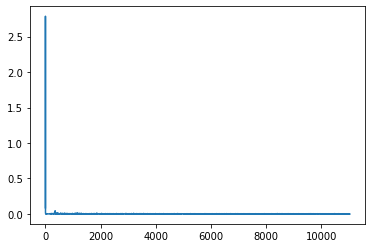

In [17]:
import matplotlib.pyplot as plt
plt.plot(losses)

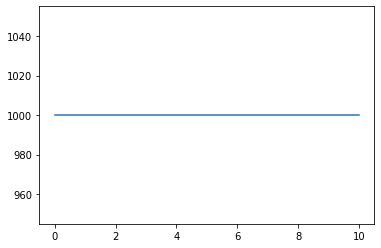

In [18]:
plt.plot(steps2finish)

In [12]:
policy = np.empty((rows, cols))
for row in range(rows):
    for col in range(cols):
        policy[row][col] = torch.argmax(agent.QNet(torch.tensor((row,col)).float()))

In [13]:
policy

array([[2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2.]])